In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = 'data/'

In [3]:
class HackathonDataset(Dataset):
    """Hackathon Dataset"""   
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with paths and labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform    
        
    def __len__(self):
        return len(self.file)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        
        img_file = self.file.iloc[idx]["image_file_name"]        
        if "22NCL" in img_file:
            img_dir= "guyane/guyane/"
        elif "28PCC" in img_file:
            img_dir = "saint_louis/saint_louis/"  
        elif "29SMD" in img_file:
            img_dir = "dataset_29SMD/dataset_29SMD/"  
        elif "29TNE" in img_file:
            img_dir = "dataset_29TNE/dataset_29TNE/"
        else:
            raise Exception('There is something wrong with image name')    
        image = np.load(self.root_dir + img_dir + img_file + ".npy")
        image = np.moveaxis(image, -1, 0)  # Permute dimensions in order to have Cin, H, W instead of H, W, Cin
        image = image.astype(np.float32)  # We work with float (float32), not double (float64)
        target = self.file.iloc[idx]["z"]
        target = target.astype(np.float32)  # We work with float (float32), not double (float64)
        sample = {'image': image, 'z': target}        
        if self.transform:
            sample = self.transform(sample)        
        return sample

In [4]:
class Net(nn.Module):
    """Used Network"""

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(4, 8, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(1600, 160)  # 6*6 from image dimension
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(160, 1)
        self.relu4 = nn.ReLU()
        
    def forward(self, x):
        """Given a tensor X of shape (Batch_size, C_in, H, W), compute the output tensor, of shape (Batch_size, )"""
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.flatten(start_dim=1)  # Flatten the 3 last dimensions, keep the 1 dimension (batch_size)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = x.flatten()  # The output dimension should be (Batch_size, ) and not (Batch_size, 1) 
        return x

In [5]:
n_epochs = 5
batch_size = 32

In [7]:
dataset = HackathonDataset(DATA_DIR + 'mixed_train.csv', DATA_DIR)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [16]:
batch_losses = []

for epoch in range(n_epochs):
    
    # Print Epoch
    print(f"Epoch {epoch + 1}/{n_epochs}")
    
    # Training loop
    for it, batch in enumerate(dataloader):
                
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward propagation through the network
        out = model(batch["image"])
        
        # Calculate the loss
        loss = torch.sqrt(criterion(out, batch["z"]))  # We take square root because RMSE is the competition's metric
        
        # Track batch loss
        batch_losses.append(loss.item())
        
        # Backpropagation
        loss.backward()
        
        # Update the parameters
        optimizer.step()
    
        #=====Printing part======
        if it%100 == 0:
            print(f"Number of sample viewed : {it*batch_size}")

Epoch 1/5
Number of sample viewed : 0
Number of sample viewed : 3200
Number of sample viewed : 6400
Number of sample viewed : 9600
Number of sample viewed : 12800
Number of sample viewed : 16000
Number of sample viewed : 19200
Number of sample viewed : 22400
Number of sample viewed : 25600
Number of sample viewed : 28800
Number of sample viewed : 32000
Number of sample viewed : 35200
Number of sample viewed : 38400
Number of sample viewed : 41600
Number of sample viewed : 44800
Number of sample viewed : 48000
Number of sample viewed : 51200
Number of sample viewed : 54400
Epoch 2/5
Number of sample viewed : 0
Number of sample viewed : 3200
Number of sample viewed : 6400
Number of sample viewed : 9600
Number of sample viewed : 12800
Number of sample viewed : 16000
Number of sample viewed : 19200
Number of sample viewed : 22400
Number of sample viewed : 25600
Number of sample viewed : 28800
Number of sample viewed : 32000
Number of sample viewed : 35200
Number of sample viewed : 38400
Nu

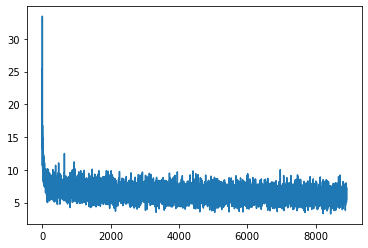

In [17]:
plt.plot(batch_losses)